<a href="https://colab.research.google.com/github/luckyrajyemul-035/BB84-Simulation/blob/main/BB84_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-aer matplotlib numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import Aer

%matplotlib inline


In [ ]:
# ---------------- Helper Functions ----------------

def prepare_qubit(bit, basis):
    qc = QuantumCircuit(1, 1)
    if bit == 1:
        qc.x(0)
    if basis == 'D':
        qc.h(0)
    return qc

def measure_qubit(qc, basis):
    if basis == 'D':
        qc.h(0)
    qc.measure(0, 0)
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(qc, shots=1).result()
    counts = result.get_counts()
    return int(list(counts.keys())[0])

def generate_bases(choice, num_bits):
    if choice == 'R':
        return ['R'] * num_bits
    elif choice == 'D':
        return ['D'] * num_bits
    else:
        return np.random.choice(['R', 'D'], size=num_bits)

In [ ]:
def bb84_simulation(num_bits, alice_basis_choice, bob_basis_choice,
                    eve_present, eve_basis_choice):

    alice_bits = np.random.randint(2, size=num_bits)
    alice_bases = generate_bases(alice_basis_choice, num_bits)
    bob_bases = generate_bases(bob_basis_choice, num_bits)
    bob_results = np.zeros(num_bits, dtype=int)

    if eve_present:
        eve_bases = generate_bases(eve_basis_choice, num_bits)

    for i in range(num_bits):
        qc = prepare_qubit(alice_bits[i], alice_bases[i])

        if eve_present:
            eve_qc = qc.copy()
            eve_result = measure_qubit(eve_qc, eve_bases[i])
            qc = prepare_qubit(eve_result, eve_bases[i])

        bob_qc = qc.copy()
        bob_results[i] = measure_qubit(bob_qc, bob_bases[i])

    matching_indices = [
        i for i in range(num_bits)
        if alice_bases[i] == bob_bases[i]
    ]

    alice_key = alice_bits[matching_indices]
    bob_key = bob_results[matching_indices]

    errors = np.sum(alice_key != bob_key)
    error_rate = errors / len(alice_key) if len(alice_key) > 0 else 0

    return error_rate, alice_key, bob_key


In [ ]:
def encrypt_message(message, key_bits):
    message_bits = ''.join(format(ord(c), '08b') for c in message)
    key_stream = ''.join(str(b) for b in key_bits)
    key_stream = (key_stream * ((len(message_bits) // len(key_stream)) + 1))[:len(message_bits)]

    cipher_bits = ''.join(
        '0' if m == k else '1'
        for m, k in zip(message_bits, key_stream)
    )
    return cipher_bits

def decrypt_message(cipher_bits, key_bits):
    key_stream = ''.join(str(b) for b in key_bits)
    key_stream = (key_stream * ((len(cipher_bits) // len(key_stream)) + 1))[:len(cipher_bits)]

    message_bits = ''.join(
        '0' if c == k else '1'
        for c, k in zip(cipher_bits, key_stream)
    )

    chars = [
        chr(int(message_bits[i:i+8], 2))
        for i in range(0, len(message_bits), 8)
    ]
    return ''.join(chars)


In [ ]:
def plot_error_histogram(num_runs, num_bits, alice_basis, bob_basis,
                         eve_present, eve_basis):

    error_rates = []

    for _ in range(num_runs):
        error_rate, _, _ = bb84_simulation(
            num_bits,
            alice_basis,
            bob_basis,
            eve_present,
            eve_basis
        )
        error_rates.append(error_rate)

    plt.figure()
    plt.hist(error_rates, bins=10)
    plt.xlabel("Error Rate")
    plt.ylabel("Frequency")
    plt.title("BB84 Error Rate Histogram")
    plt.show()


In [ ]:
NUM_QUBITS = 5000

ALICE_BASIS = 'Random'    # 'R', 'D', or 'Random'
BOB_BASIS   = 'Random'    # 'R', 'D', or 'Random'

EVE_PRESENT = False       # True or False
EVE_BASIS   = 'Random'    # 'R', 'D', or 'Random'

MESSAGE = "HELLO QUANTUM"

HISTOGRAM_RUNS = 50       # Set 0 to skip histogram


===== BB84 Secure Communication System =====
Error rate: 0.000
Secure key established.
Key length: 2503

Original message:
HELLO QUANTUM

Encrypted message (binary):
00110001000000001010000110100001001110011011101010000110110110011001000101001000000001110000111111111111

Decrypted message:
HELLO QUANTUM


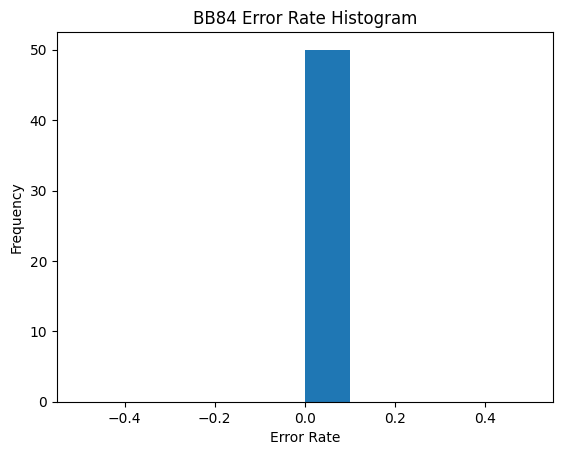

In [ ]:
print("===== BB84 Secure Communication System =====")

error_rate, alice_key, bob_key = bb84_simulation(
    NUM_QUBITS,
    ALICE_BASIS,
    BOB_BASIS,
    EVE_PRESENT,
    EVE_BASIS
)

print(f"Error rate: {error_rate:.3f}")

if error_rate < 0.1:
    print("Secure key established.")
    print(f"Key length: {len(alice_key)}")

    cipher = encrypt_message(MESSAGE, alice_key)
    decrypted = decrypt_message(cipher, alice_key)

    print("\nOriginal message:")
    print(MESSAGE)

    print("\nEncrypted message (binary):")
    print(cipher)

    print("\nDecrypted message:")
    print(decrypted)
else:
    print("Eavesdropping detected. Communication aborted.")

if HISTOGRAM_RUNS > 0:
    plot_error_histogram(
        HISTOGRAM_RUNS,
        NUM_QUBITS,
        ALICE_BASIS,
        BOB_BASIS,
        EVE_PRESENT,
        EVE_BASIS
    )
